### fMRI Dimensionality Reduction

### Notebook setup

In [1]:
# NiLearn
from nilearn.datasets import fetch_development_fmri
import nilearn.plotting as plotting
from nilearn import image
from scipy.stats import zscore

# Nibabel to access file formats
import nibabel as nib

# Numpy to deal with arrays
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("RdBu")

# Built in python libraries
import random

# Set random seed for reproducibility
SEED = 11
random.seed(11)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Load the data

The `data` variable is a `Bunch` (dict. like object) with the following attributes:

- `func (list of str)`: Paths to downsampled functional MRI data (4D) for each subject.

- `confounds (list of str)`: Paths to confounds related to each subject. (tsv files)

- `phenotypic (numpy.ndarray)`: Contains each subject age, age group, child or adult, gender, handedness.

In [2]:
# Load the data using the nilearn's fetcher
global N_SUBJECTS 
N_SUBJECTS = 25

data = fetch_development_fmri(n_subjects=N_SUBJECTS, data_dir='./data', resume=True, verbose=1)

# Check the path to the data
print(f"First subject functional nifti images (4D) are at: {data.func[0]}")

First subject functional nifti images (4D) are at: ./data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


In [3]:
# Initialize features from dataset's description
global IPS
IPS = 168 
global N_SLICES
N_SLICES = 50 
global X_DIM
X_DIM = 50
global Y_DIM 
Y_DIM = 59

### Check the phenotypic data

Let's load the phenotypic data into a pandas dataframe to check the data.

In [4]:
# Convert the phenotypic data into a pandas dataframe ensuring the correct data types
data_types = {
    'participant_id': str,
    'Age': int,
    'AgeGroup': str,
    'Child_Adult': str,
    'Gender': str,
    'Handedness': str,
}
phenotypic = pd.DataFrame(data.phenotypic, columns=data_types.keys()).astype(data_types)

# Check the phenotypic data
phenotypic.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27,Adult,adult,F,R
1,sub-pixar124,33,Adult,adult,M,R
2,sub-pixar125,31,Adult,adult,M,R
3,sub-pixar126,19,Adult,adult,F,R
4,sub-pixar127,23,Adult,adult,F,R


Let's plot the distributions of the individual variables.

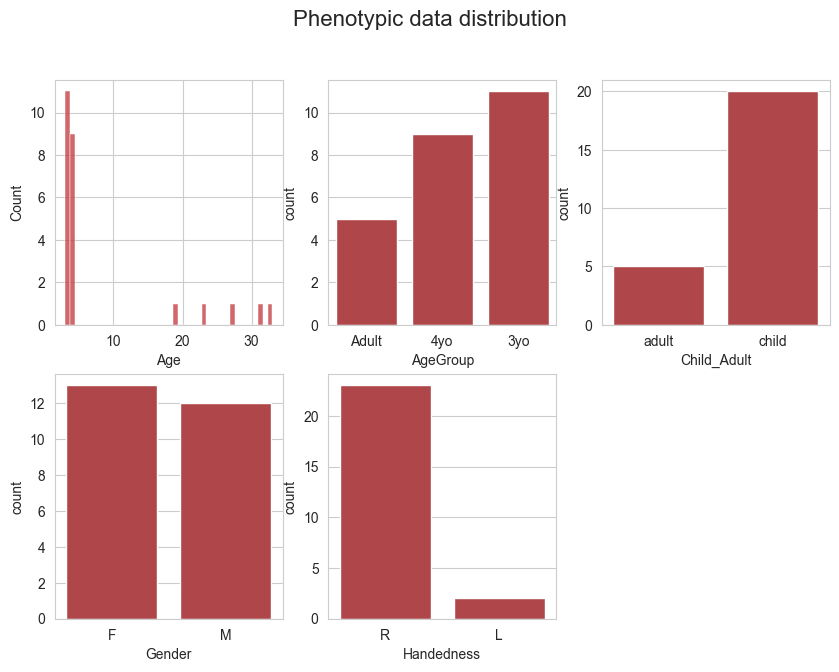

In [5]:
# The figure will have 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(10, 7))

# Plot the distribution of the age
sns.histplot(data=phenotypic, x="Age", ax=axs[0, 0], kde=False);

# Plot the categorical vars
sns.countplot(data=phenotypic, x='AgeGroup', ax=axs[0, 1])
sns.countplot(data=phenotypic, x='Child_Adult', ax=axs[0, 2])
sns.countplot(data=phenotypic, x='Gender', ax=axs[1, 0])
sns.countplot(data=phenotypic, x='Handedness', ax=axs[1, 1])

# Turn of the last axis
axs[1, 2].axis('off');

# Set the title
fig.suptitle("Phenotypic data distribution", fontsize=16);

# Save the figure
fig.savefig('figures/phenotypic_data_distribution.png', dpi=300)

### Visualize the subject

Let's dive into visualization of random subject.

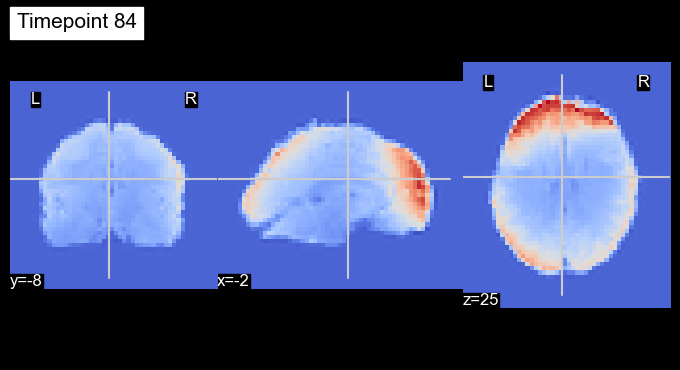

In [6]:
# Select a random subject 
subj_i = np.random.randint(0, N_SUBJECTS-1)

# Plot fMRI 3D volume (we choose the timepoint in the middle of the acquisition)
subj_vol = nib.load(data.func[subj_i])
TR_i = round(IPS/2) 
plotting.plot_epi(image.index_img(subj_vol, TR_i),  cmap = 'coolwarm', title=f"Timepoint {TR_i}")
plt.show()


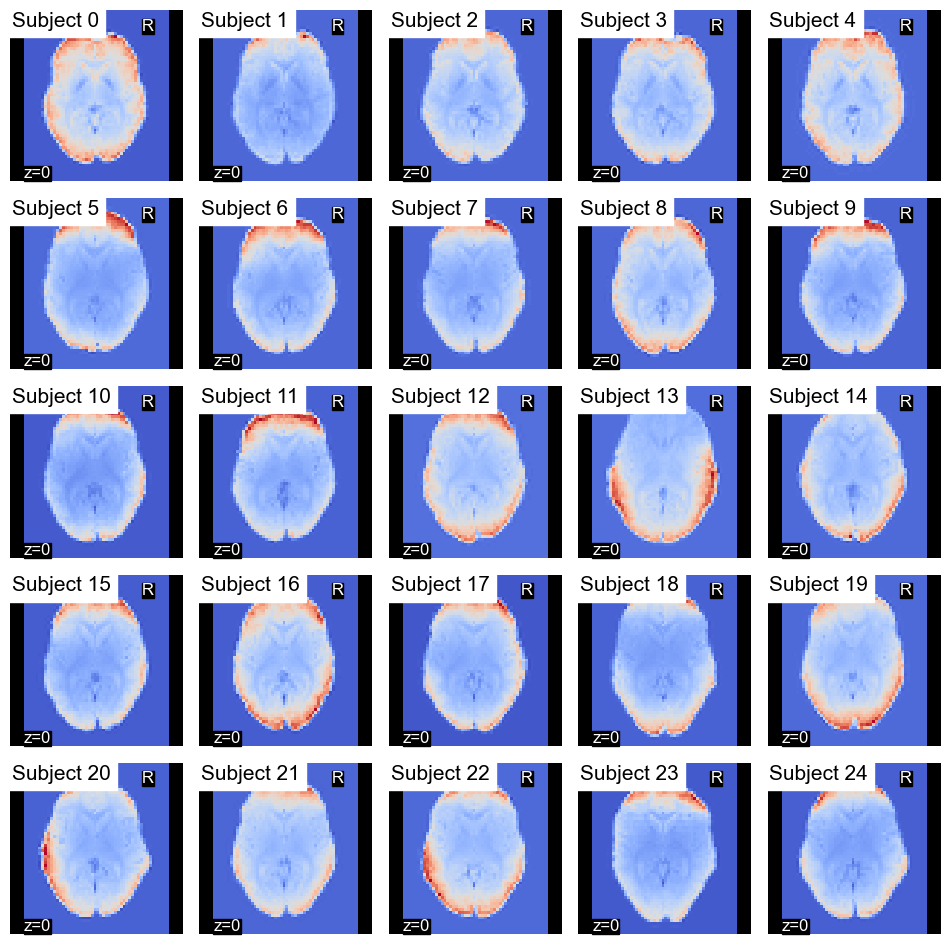

In [7]:
#HOW TO ALIGN THEMMMMMM ???????????????
# Create a figure with subplots arranged in a 5x5 grid
fig = plt.figure(figsize=(12, 12))
TR_i = round(IPS / 2)
# Define the specific z-coordinate (axial slice) where you want to align the subplots
fixed_cut_coords = 0 

# Define the position and size of the subplot grid
grid = plt.GridSpec(5, 5, wspace=0.1, hspace=0.1)

# Loop through subjects and plot the images
for subj_i in range(N_SUBJECTS):
    subj_vol = nib.load(data.func[subj_i])
    img = image.index_img(subj_vol, TR_i)

    row, col = subj_i // 5, subj_i % 5
    ax = fig.add_subplot(grid[row, col])
    plotting.plot_epi(img, display_mode='z', cut_coords=[fixed_cut_coords], cmap='coolwarm', title=f"Subject {subj_i}", axes=ax)
    ax.axis('off')

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()


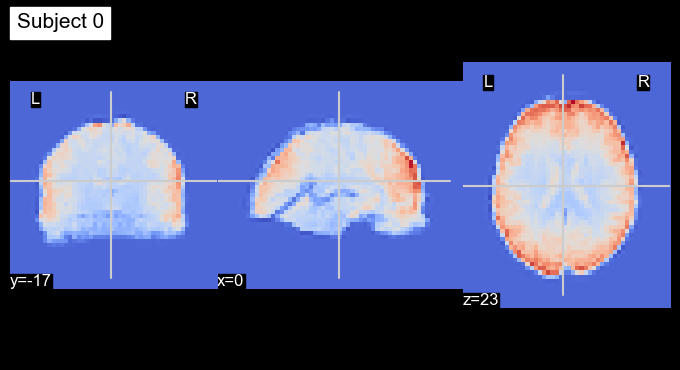

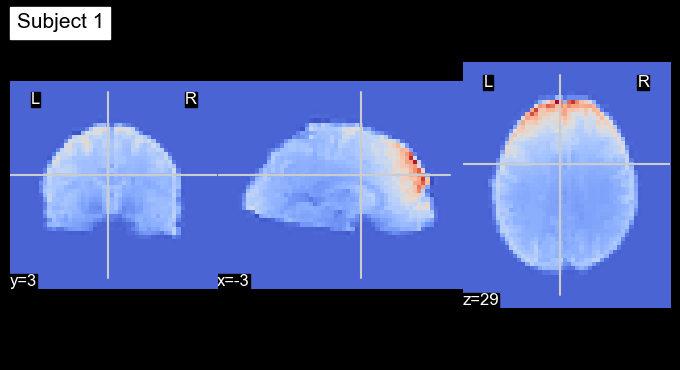

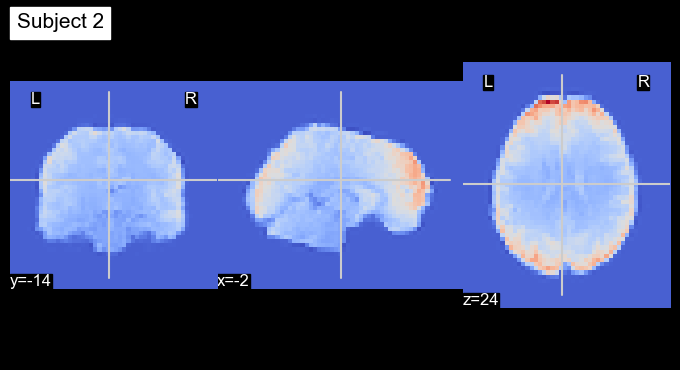

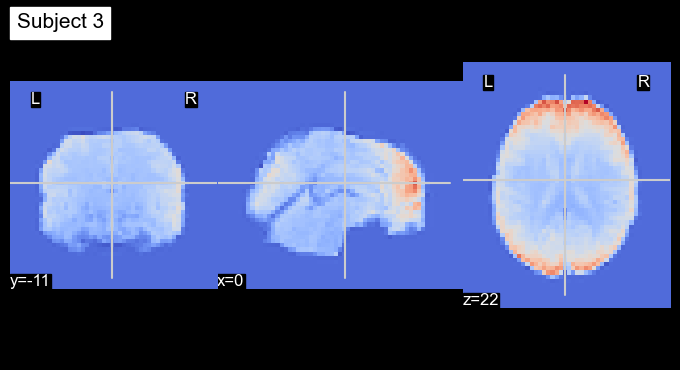

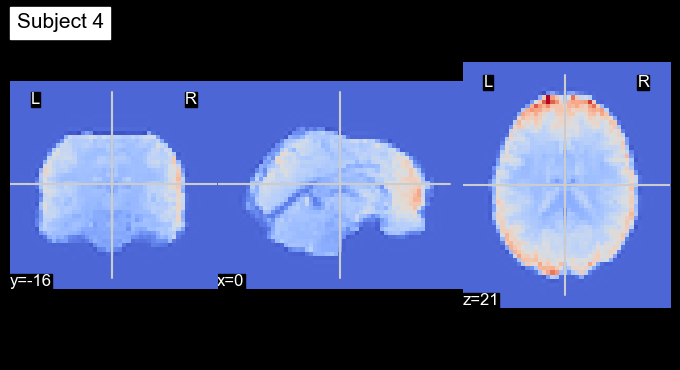

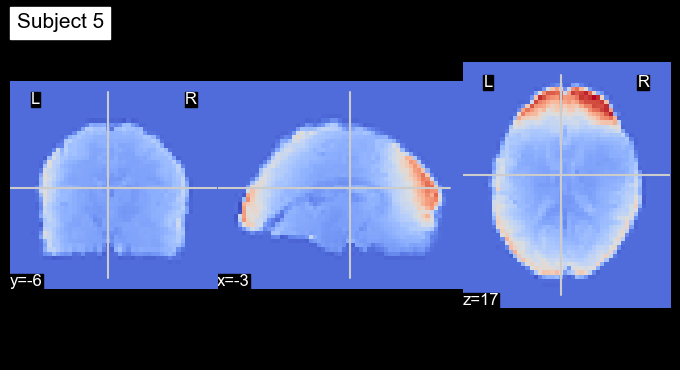

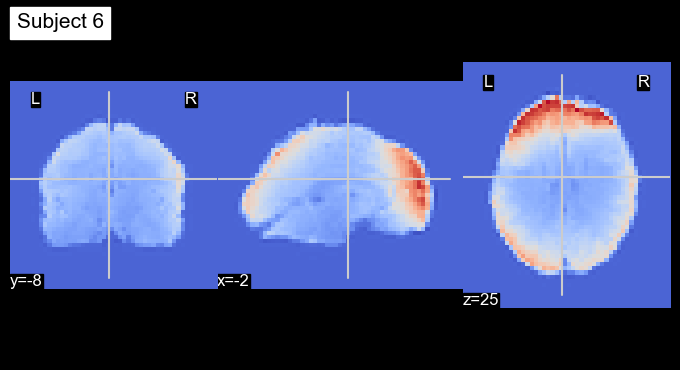

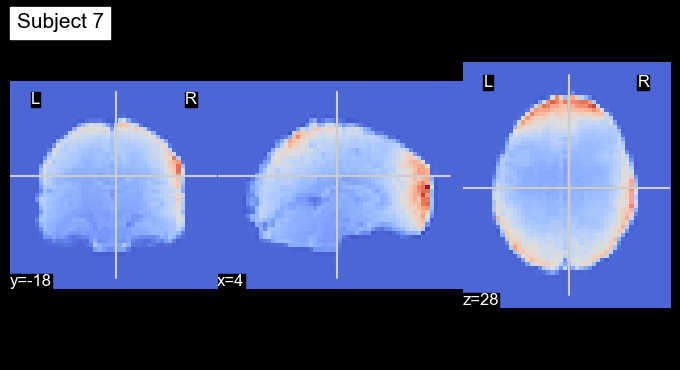

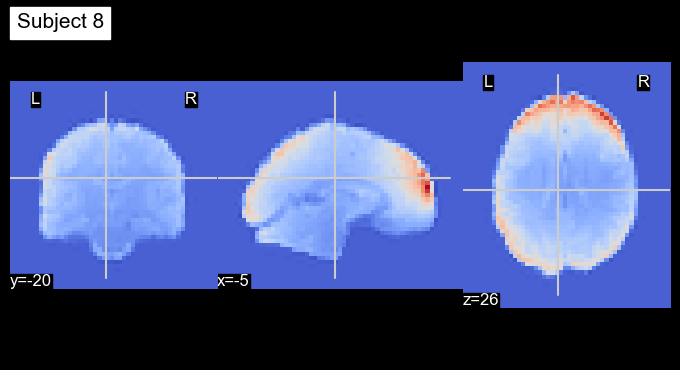

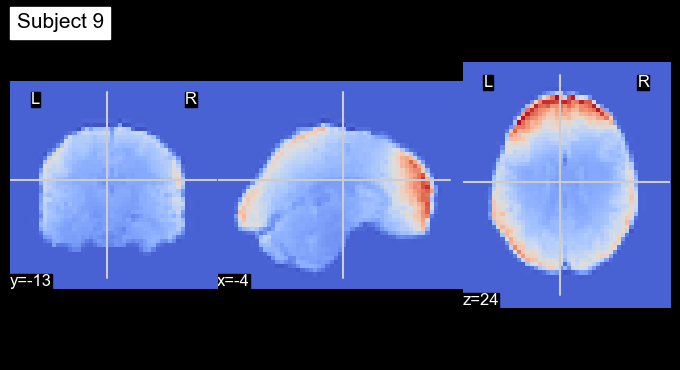

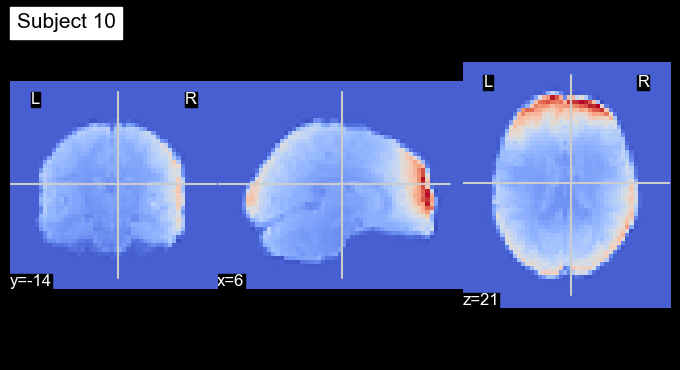

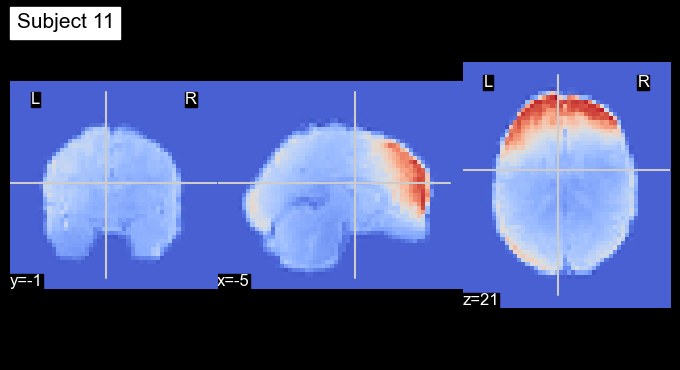

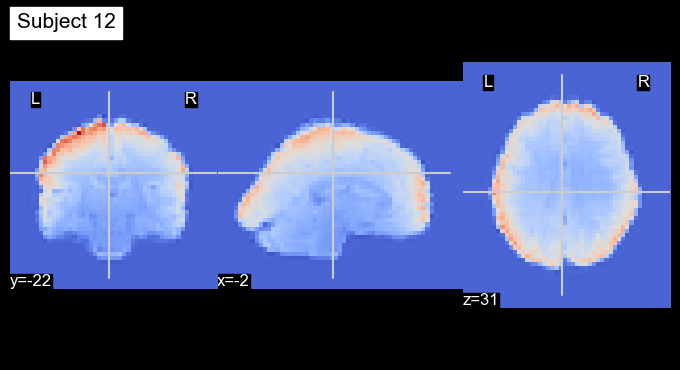

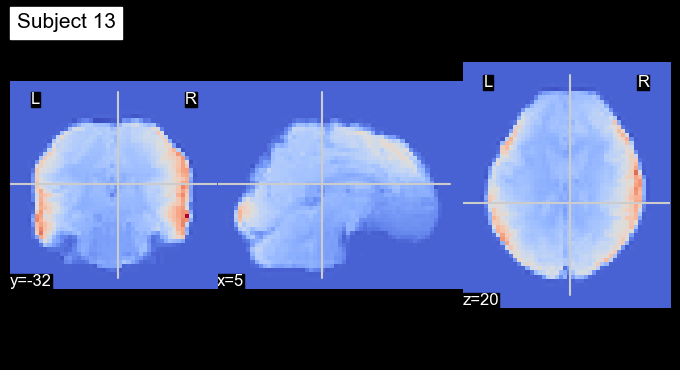

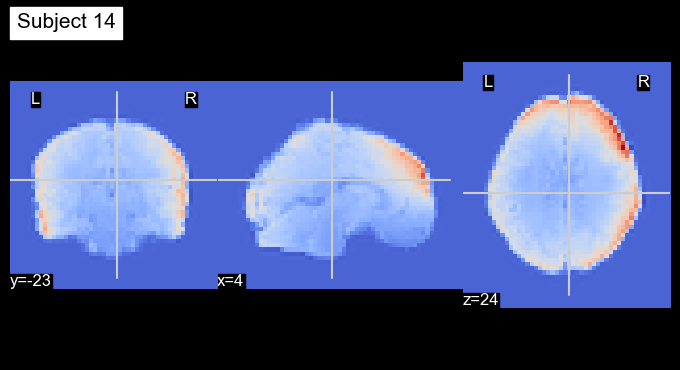

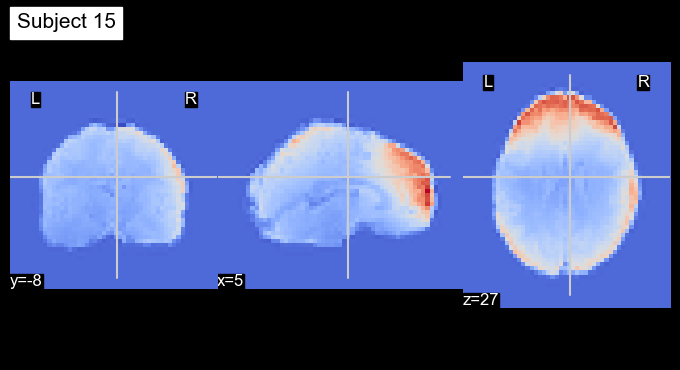

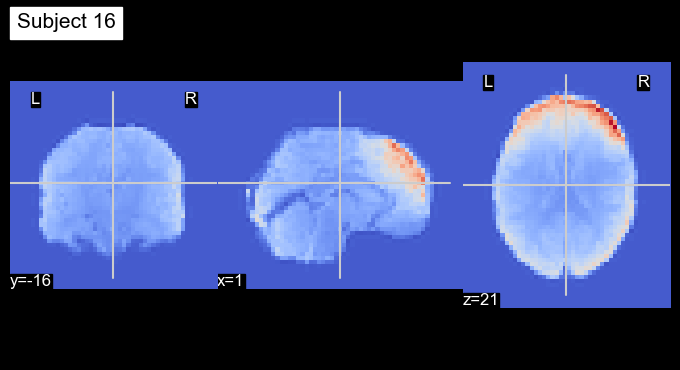

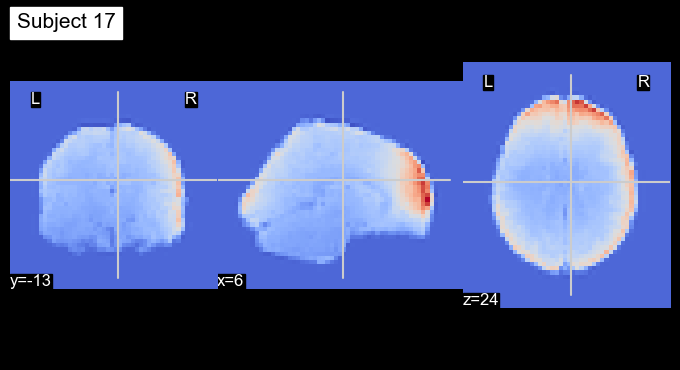

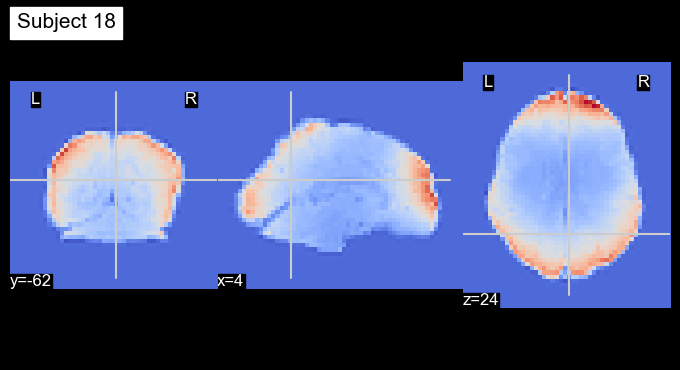

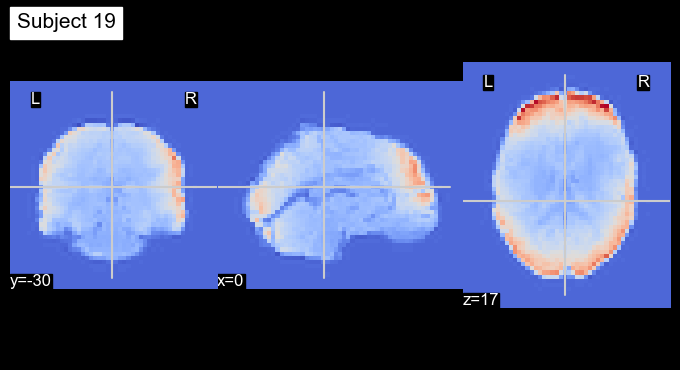

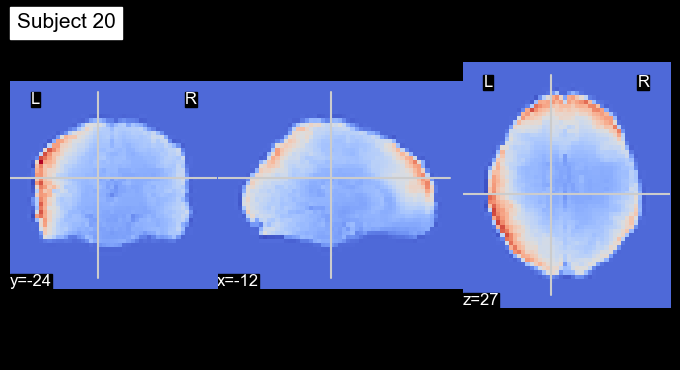

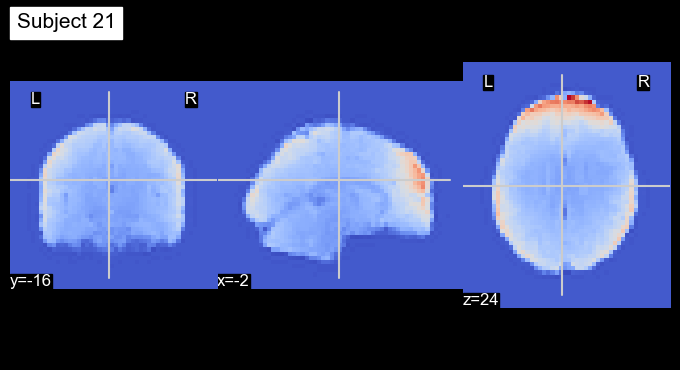

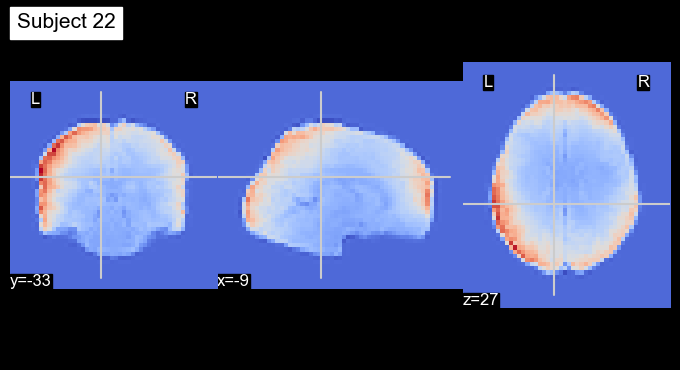

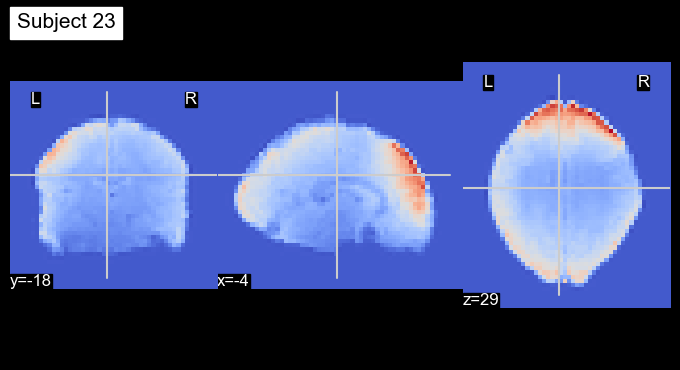

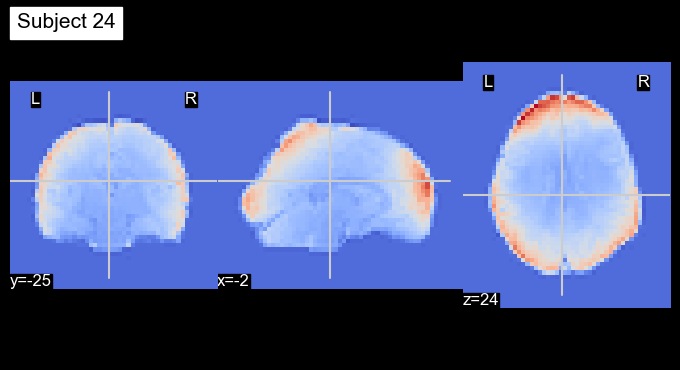

In [8]:
for subj_i in range(N_SUBJECTS):
    # Plot fMRI 3D volume (we choose the timepoint in the middle of the acquisition)
    subj_vol = nib.load(data.func[subj_i])
    TR_i = round(IPS/2) 
    plotting.plot_epi(image.index_img(subj_vol, TR_i),  cmap = 'coolwarm', title=f"Subject {subj_i}")
    plt.show()


### Initialize matrices and add noise

We now load the NIFTI images as numpy matrices, and store them in a x_dim x y_dim x n_subj matrix.
To do so, we must select a TR and slice. We choose the middle TR for effect compensation and middle slice since z coordinate in the middle allows for better visualization.

The code loads fMRI data from multiple subjects, storing the 4D data (representing multiple volumes in 3D space over time) for each subject in one list (matrices_4D) and the 2D data (a single 2D slice at a specific TR and slice) in another list (matrices_2D). 

In [9]:
# Now we choose a TR
TR = round(IPS/2)

# and a slice 
sel_slice = round(N_SLICES/2)

# Now we import each NIFTI image as numpy matrix, then select desired TR+slice
matrices_4D = []
matrices_2D = []
for i in range(N_SUBJECTS):
    img_i = nib.load(data.func[i])
    mat_i = img_i.get_fdata()
    #print(f"Upload of subject {i} completed...")
    matrices_4D.append(mat_i)
    matrices_2D.append(mat_i[:,:,sel_slice, TR])         #choose slice and TR
matrices_2D_array= np.array(matrices_2D)
print(matrices_2D_array.shape)
print("Matrices loaded.")

(25, 50, 59)
Matrices loaded.


In [10]:
# Add salt (white) noise by randomly setting some pixels of the matrix to 255
salt_int_1 = 400
salt_int_2 = 2200
salt_int_3 = 4400  # Max pixel value
salt_p = 0.01  # Probability of adding the noise

# Iterate over pixels and matrices 
noisy_mats_1 = []
noisy_mats_2 = []
noisy_mats_3 = []
for k in range(N_SUBJECTS):
    noisy_mat_1 = np.copy(matrices_2D[k])        #initialize the noisy matrix by copying it
    noisy_mat_2 = np.copy(matrices_2D[k]) 
    noisy_mat_3 = np.copy(matrices_2D[k]) 
    for i in range(noisy_mat_1.shape[0]):        # 50 times
        for j in range(noisy_mat_1.shape[1]):    # 59
            if random.random() < salt_p:       #checks if a random number (generated by random.random()) is less than the specified salt noise probability (salt_p).
                noisy_mat_1[i,j] = salt_int_1 #for each pixel, if the condition is met, the pixel value at [i, j] is set to the maximum pixel value (salt_int) to simulate salt noise
                noisy_mat_2[i,j] = salt_int_2 
                noisy_mat_3[i,j] = salt_int_3
    noisy_mats_1.append(noisy_mat_1)
    noisy_mats_2.append(noisy_mat_2)
    noisy_mats_3.append(noisy_mat_3)

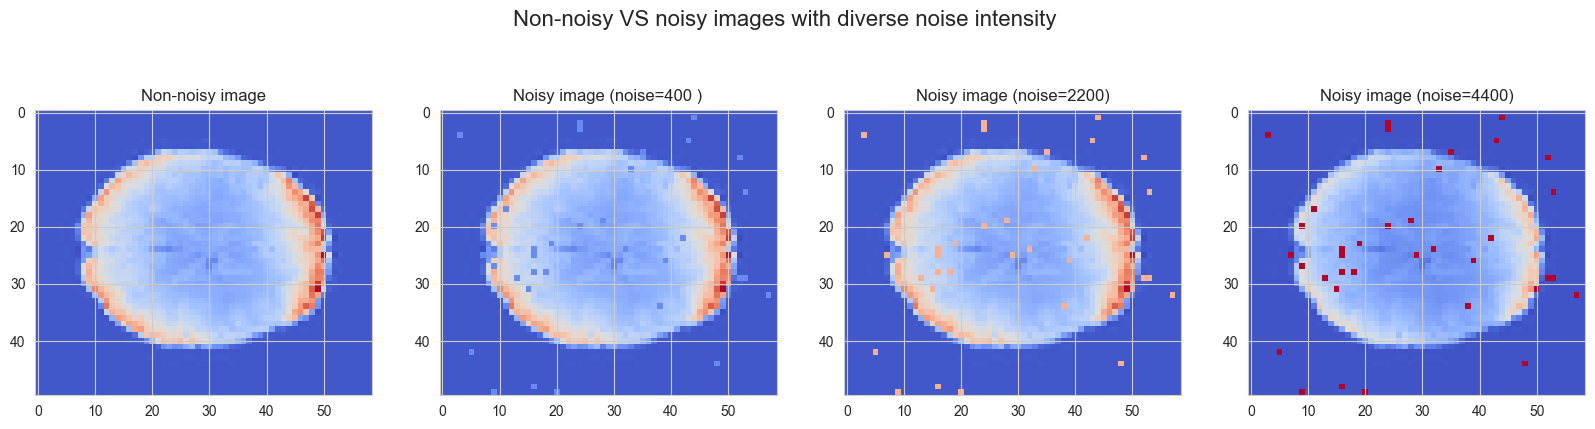

In [58]:
# Evaluate the result on a random subject
subj_i = np.random.randint(0, N_SUBJECTS-1)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot the non-noisy image
axes[0].imshow(matrices_2D[subj_i], cmap='coolwarm')
axes[0].set_title('Non-noisy image')

# Plot the noisy image (noise intensity of 400)
axes[1].imshow(noisy_mats_1[subj_i], cmap='coolwarm')
axes[1].set_title('Noisy image (noise=400 )')

# Plot the noisy image (noise intensity of 2200)
axes[2].imshow(noisy_mats_2[subj_i], cmap='coolwarm')
axes[2].set_title('Noisy image (noise=2200)')

# Plot the noisy image (noise intensity of 4400)
axes[3].imshow(noisy_mats_3[subj_i], cmap='coolwarm')
axes[3].set_title('Noisy image (noise=4400)')

# Overall title for the panel of figures
fig.suptitle('Non-noisy VS noisy images with diverse noise intensity', fontsize=16)

plt.show()

### Denoising with SVD

We generate the covariance matrix across subjects, then apply SVD to it and plot the computed values for every subject. We then project each individual matrix onto its 2 principal components. Denoised matrix is then restored and compared with the original denoised matrix.

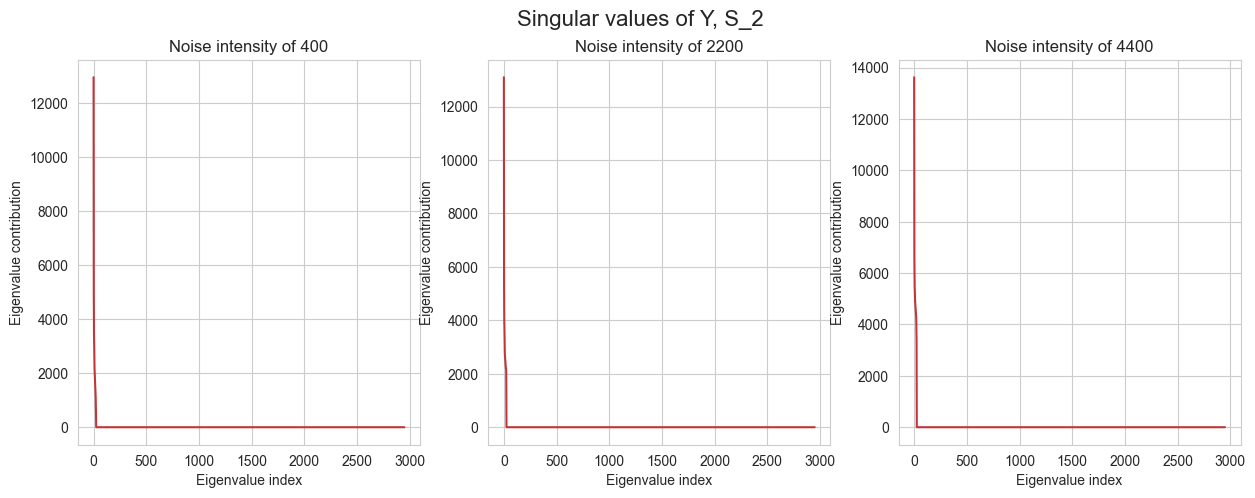

In [12]:
# Generate covariance matrix
noisy_arrays_1 = np.zeros([X_DIM*Y_DIM, N_SUBJECTS])
noisy_arrays_2 = np.zeros([X_DIM*Y_DIM, N_SUBJECTS])
noisy_arrays_3 = np.zeros([X_DIM*Y_DIM, N_SUBJECTS])

for k in range(N_SUBJECTS):
    noisy_arrays_1[:, k] = noisy_mats_1[k].flatten()
    noisy_arrays_2[:, k] = noisy_mats_2[k].flatten()
    noisy_arrays_3[:, k] = noisy_mats_3[k].flatten()

# Calculate the mean across columns and subtract it
row_means_1 = np.mean(noisy_arrays_1, axis=1, keepdims=True)
row_means_2 = np.mean(noisy_arrays_2, axis=1, keepdims=True)
row_means_3 = np.mean(noisy_arrays_3, axis=1, keepdims=True)

X1 = noisy_arrays_1 - np.tile(row_means_1, (1, N_SUBJECTS))
X2 = noisy_arrays_2 - np.tile(row_means_2, (1, N_SUBJECTS))
X3 = noisy_arrays_3 - np.tile(row_means_3, (1, N_SUBJECTS))

cov_mat_1 = np.cov(X1)
cov_mat_2 = np.cov(X2)
cov_mat_3 = np.cov(X3)

# Perform SVD
U1, S_21, V1t = np.linalg.svd(cov_mat_1, full_matrices=False)
U2, S_22, V2t = np.linalg.svd(cov_mat_2, full_matrices=False)
U3, S_23, V3t = np.linalg.svd(cov_mat_3, full_matrices=False)

# Plot singular values of Y
S1 = np.sqrt(S_21)
S2 = np.sqrt(S_22)
S3 = np.sqrt(S_23)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(S1)
ax1.set_title('Noise intensity of 400')
ax1.set_xlabel('Eigenvalue index')
ax1.set_ylabel('Eigenvalue contribution')
ax1.grid(True)

ax2.plot(S2)
ax2.set_title('Noise intensity of 2200')
ax2.set_xlabel('Eigenvalue index')
ax2.set_ylabel('Eigenvalue contribution')
ax2.grid(True)

ax3.plot(S3)
ax3.set_title('Noise intensity of 4400')
ax3.set_xlabel('Eigenvalue index')
ax3.set_ylabel('Eigenvalue contribution')
ax3.grid(True)

# Overall title for the panel of figures
fig.suptitle('Singular values of Y, S_2', fontsize=16)

plt.show()



This picture clearly shows what is the meaning of S matrix. We can see that the first eigenvalues are the one that contribute the most to the variation in the data and the more elements we add, the less their contribution will be

Text(0.5, 1.0, 'Denoised Slice - Dataset 1')

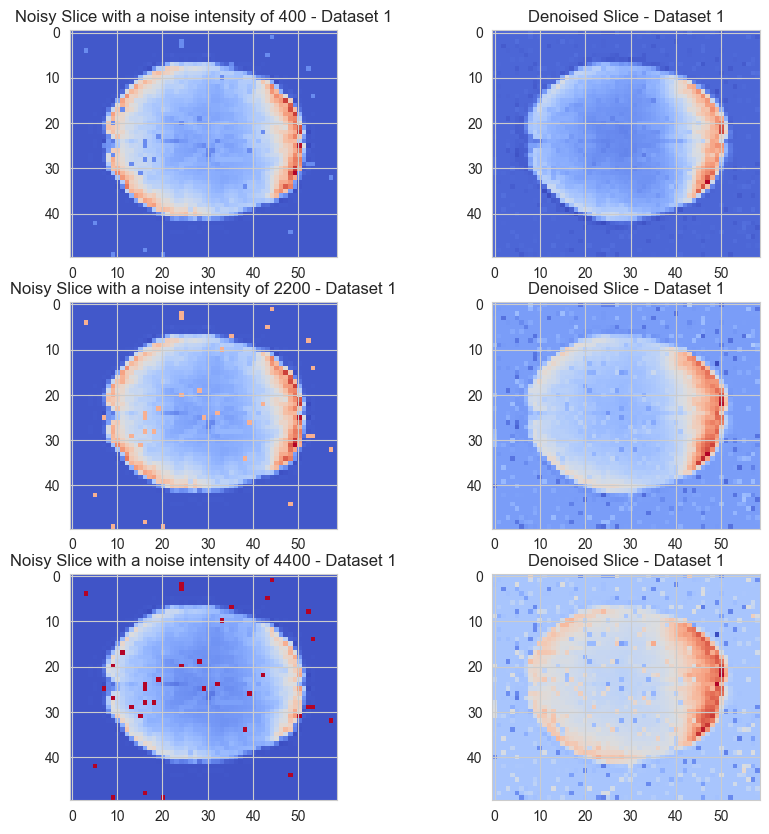

In [66]:
# Pick the 2 principal components from SVD
n_components = 1      
princ_comp_1 = U1[:,:n_components]                #stores the selected principal components (columns) from the U matrix obtained through SVD
princ_comp_2 = U2[:,:n_components]  
princ_comp_3 = U3[:,:n_components]  

#The idea is that these components represent the directions in the feature space with the most variance.
# Project the noisy image data onto the selected principal components by performing matrix multiplication. It is the noisy image in the space defined by these principal components.
space_vectors_1 = np.dot(princ_comp_1.T, noisy_arrays_1)
space_vectors_2 = np.dot(princ_comp_2.T, noisy_arrays_2)
space_vectors_3 = np.dot(princ_comp_3.T, noisy_arrays_3)

#reshapes the denoised data into the original spatial dimensions, so it can be compared to the original noisy image.
denoised_arrays_1 = np.dot(princ_comp_1, space_vectors_1)
denoised_arrays_2 = np.dot(princ_comp_2, space_vectors_2)
denoised_arrays_3 = np.dot(princ_comp_3, space_vectors_3)

denoised_matrix_1 = np.reshape(denoised_arrays_1[:, subj_i], [50,59])
denoised_matrix_2 = np.reshape(denoised_arrays_2[:, subj_i], [50,59])
denoised_matrix_3 = np.reshape(denoised_arrays_3[:, subj_i], [50,59])

#The result is an approximation of the original data but reduced in dimensionality due to the number of principal components used
# Visualize it
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Plot the noisy images and denoised images
axs[0, 0].imshow(noisy_mats_1[subj_i], cmap='coolwarm')
axs[0, 0].set_title('Noisy Slice with a noise intensity of 400 - Dataset 1')

axs[0, 1].imshow(denoised_matrix_1, cmap='coolwarm')
axs[0, 1].set_title('Denoised Slice - Dataset 1')

axs[1, 0].imshow(noisy_mats_2[subj_i], cmap='coolwarm')
axs[1, 0].set_title('Noisy Slice with a noise intensity of 2200 - Dataset 1')

axs[1, 1].imshow(denoised_matrix_2, cmap='coolwarm')
axs[1, 1].set_title('Denoised Slice - Dataset 1')

axs[2, 0].imshow(noisy_mats_3[subj_i], cmap='coolwarm')
axs[2, 0].set_title('Noisy Slice with a noise intensity of 4400 - Dataset 1')

axs[2, 1].imshow(denoised_matrix_3, cmap='coolwarm')
axs[2, 1].set_title('Denoised Slice - Dataset 1')

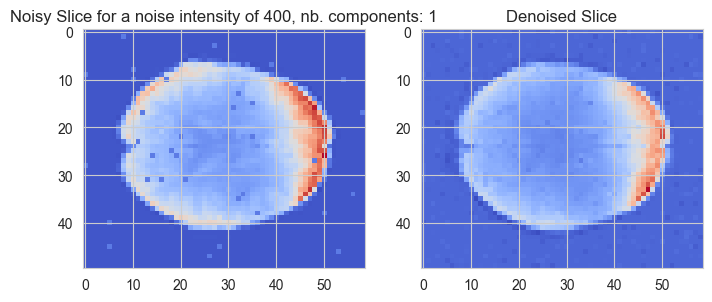

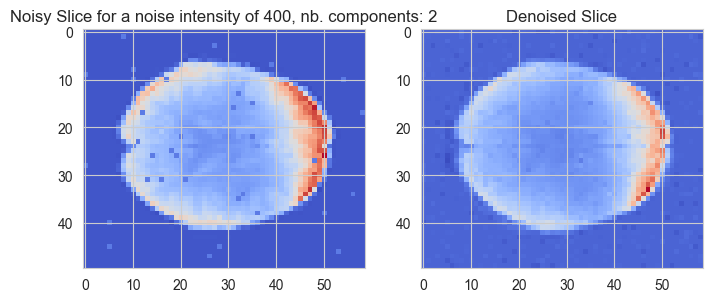

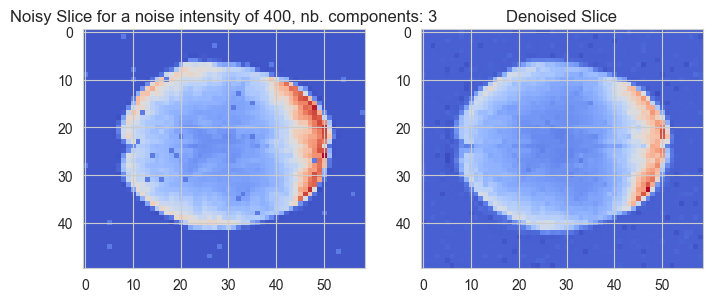

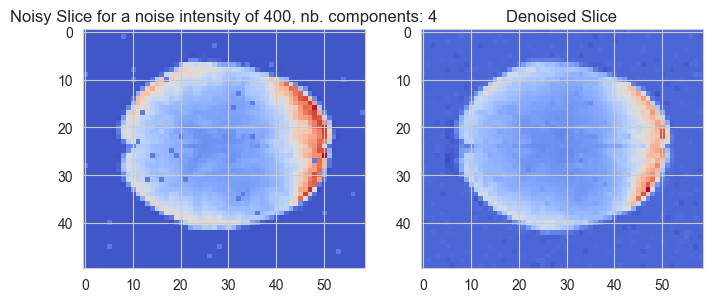

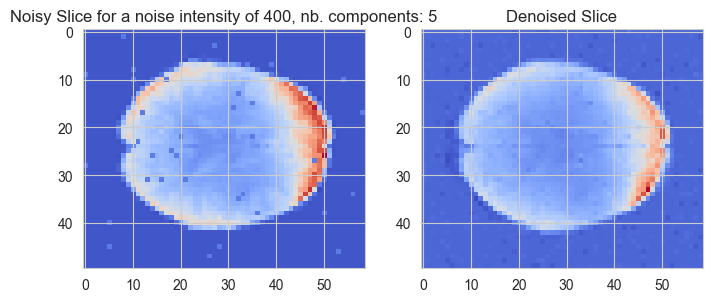

In [53]:
# Pick the principal components from SVD
n_components = [1,2,3,4,5]     
for n in n_components:
    princ_comp_1 = U1[:,:n]                #stores the selected principal components (columns) from the U matrix obtained through SVD

    #The idea is that these components represent the directions in the feature space with the most variance.
    # Project the noisy image data onto the selected principal components by performing matrix multiplication. It is the noisy image in the space defined by these principal components.
    space_vectors_1 = np.dot(princ_comp_1.T, noisy_arrays_1)      #U.T *Y_tilda
    denoised_arrays_1 = np.dot(princ_comp_1, space_vectors_1)     #Y_tilda = U * A.T
    
    #reshapes the denoised data into the original spatial dimensions, so it can be compared to the original noisy image.
    denoised_matrix_1 = np.reshape(denoised_arrays_1[:, subj_i], [50,59])
    #The result is an approximation of the original data but reduced in dimensionality due to the number of principal components used
    # Visualize it
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(noisy_mats_1[subj_i], cmap='coolwarm')
    plt.title(f'Noisy Slice for a noise intensity of 400, nb. components: {n}')

    plt.subplot(1, 2, 2)
    plt.imshow(denoised_matrix_1, cmap='coolwarm')
    plt.title('Denoised Slice')

    plt.show()

--> Analysis: we can suppose that for this data, adding more components has no particular effect on image denoising
HOWEVER NOT CLEAR because of values of noise, solve with assisstants which value we should use!!

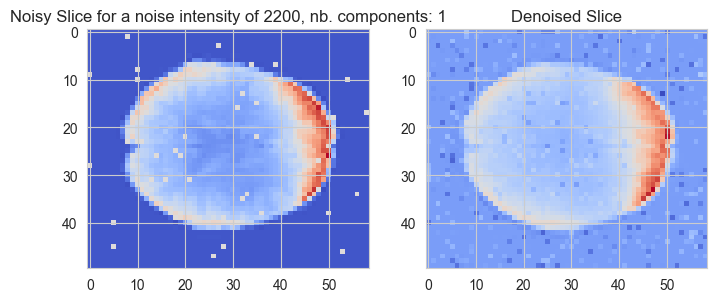

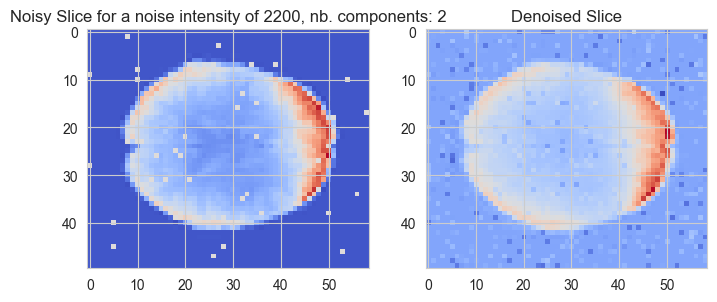

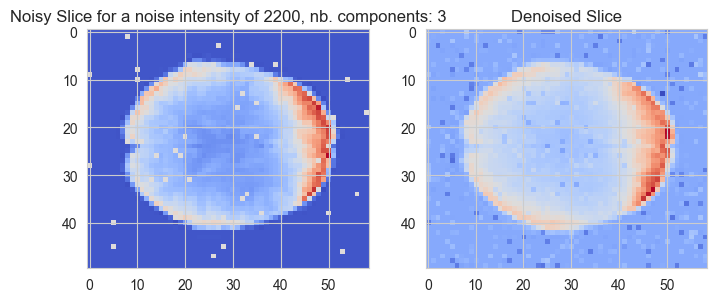

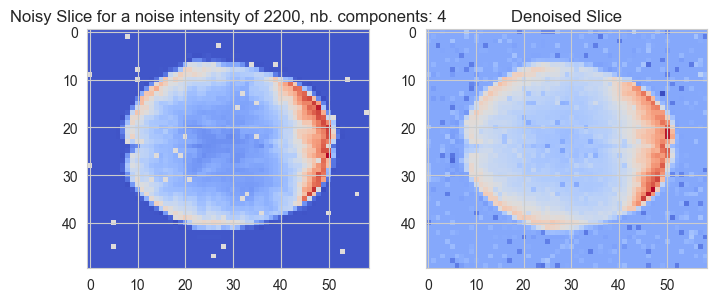

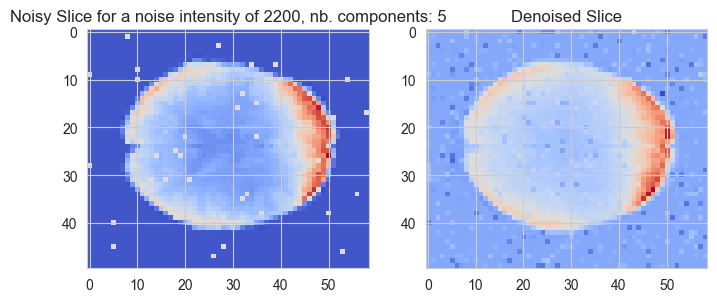

In [51]:
# Pick the 2 principal components from SVD     
for n in n_components:
    princ_comp_2 = U2[:,:n]                #stores the selected principal components (columns) from the U matrix obtained through SVD

    #The idea is that these components represent the directions in the feature space with the most variance.
    # Project the noisy image data onto the selected principal components by performing matrix multiplication. It is the noisy image in the space defined by these principal components.
    space_vectors_2 = np.dot(princ_comp_2.T, noisy_arrays_2)      #U.T *Y_tilda
    denoised_arrays_2 = np.dot(princ_comp_2, space_vectors_2)     #Y_tilda = U * A.T
    
    #reshapes the denoised data into the original spatial dimensions, so it can be compared to the original noisy image.
    denoised_matrix_2 = np.reshape(denoised_arrays_2[:, subj_i], [50,59])
    #The result is an approximation of the original data but reduced in dimensionality due to the number of principal components used
    # Visualize it
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(noisy_mats_2[subj_i], cmap='coolwarm')
    plt.title(f'Noisy Slice for a noise intensity of 2200, nb. components: {n}')

    plt.subplot(1, 2, 2)
    plt.imshow(denoised_matrix_2, cmap='coolwarm')
    plt.title('Denoised Slice')

    plt.show()

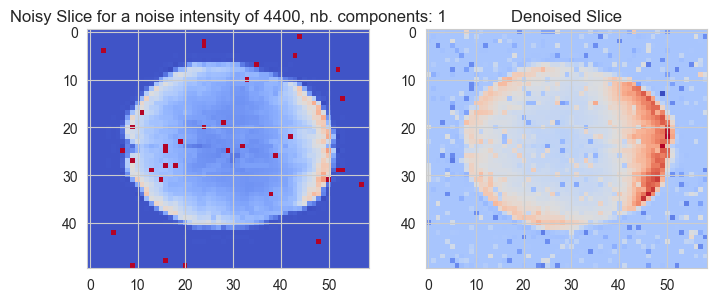

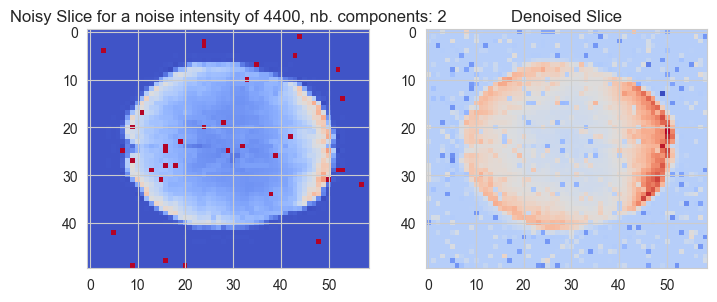

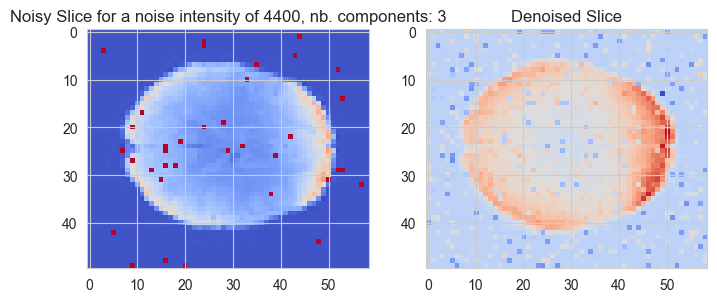

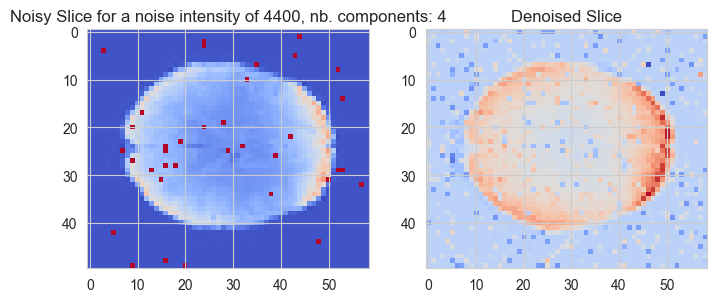

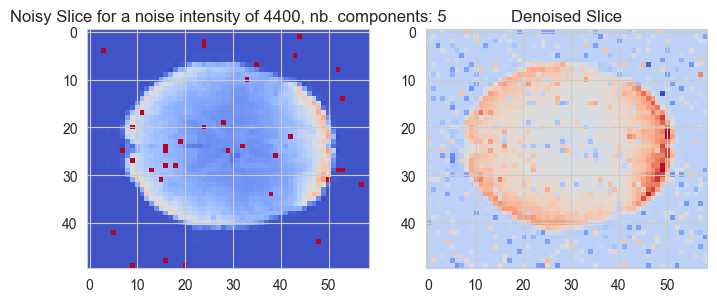

In [60]:
for n in n_components:
    princ_comp_3 = U3[:,:n]                #stores the selected principal components (columns) from the U matrix obtained through SVD

    #The idea is that these components represent the directions in the feature space with the most variance.
    # Project the noisy image data onto the selected principal components by performing matrix multiplication. It is the noisy image in the space defined by these principal components.
    space_vectors_3 = np.dot(princ_comp_3.T, noisy_arrays_3)      #U.T *Y_tilda
    denoised_arrays_3 = np.dot(princ_comp_3, space_vectors_3)     #Y_tilda = U * A.T
    
    #reshapes the denoised data into the original spatial dimensions, so it can be compared to the original noisy image.
    denoised_matrix_3 = np.reshape(denoised_arrays_3[:, subj_i], [50,59])
    #The result is an approximation of the original data but reduced in dimensionality due to the number of principal components used
    # Visualize it
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(noisy_mats_3[subj_i], cmap='coolwarm')
    plt.title(f'Noisy Slice for a noise intensity of 4400, nb. components: {n}')

    plt.subplot(1, 2, 2)
    plt.imshow(denoised_matrix_3, cmap='coolwarm')
    plt.title('Denoised Slice')

    plt.show()

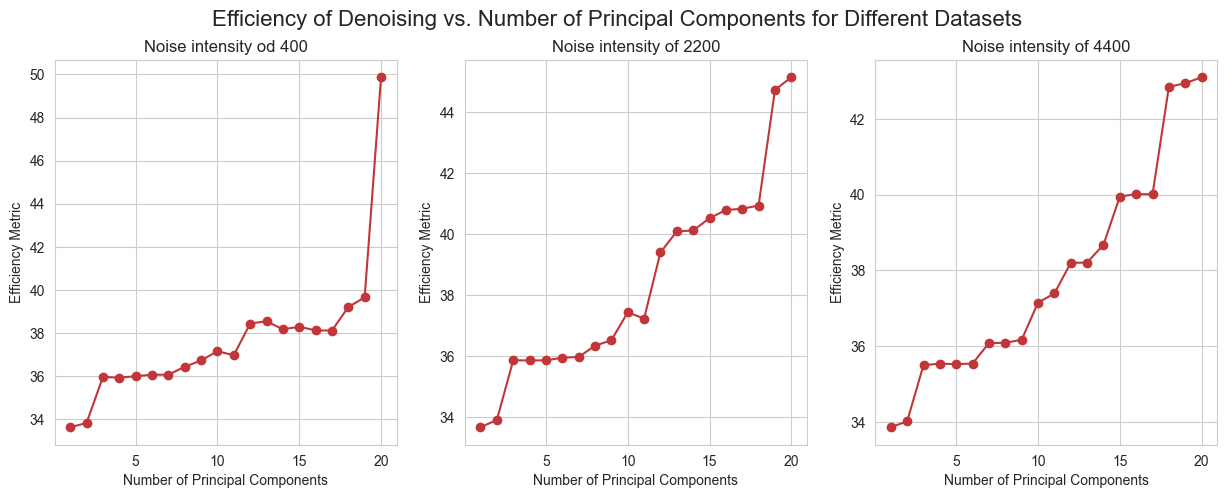

In [23]:


from skimage.metrics import peak_signal_noise_ratio

# Define a range of components to test
n_components = np.arange(1, 21)  # Adjust the range as needed
efficiency_scores_1 = []
efficiency_scores_2 = []
efficiency_scores_3 = []

for n in n_components:
    # Pick the principal components
    princ_comp_1 = U1[:, :n]
    princ_comp_2 = U2[:, :n]
    princ_comp_3 = U3[:, :n]

    # Project the noisy image data onto the selected principal components
    space_vectors_1 = np.dot(princ_comp_1.T, noisy_arrays_1)
    space_vectors_2 = np.dot(princ_comp_2.T, noisy_arrays_2)
    space_vectors_3 = np.dot(princ_comp_3.T, noisy_arrays_3)
    
    denoised_arrays_1 = np.dot(princ_comp_1, space_vectors_1)
    denoised_arrays_2 = np.dot(princ_comp_2, space_vectors_2)
    denoised_arrays_3 = np.dot(princ_comp_3, space_vectors_3)  # Corrected variable name

    # Calculate an efficiency score (e.g., signal-to-noise ratio or mean squared error)
    # You can choose a relevant metric to measure the denoising efficiency
    efficiency_1 = peak_signal_noise_ratio(noisy_arrays_1[subj_i], denoised_arrays_1[subj_i], data_range=255)
    efficiency_2 = peak_signal_noise_ratio(noisy_arrays_2[subj_i], denoised_arrays_2[subj_i], data_range=255)
    efficiency_3 = peak_signal_noise_ratio(noisy_arrays_3[subj_i], denoised_arrays_3[subj_i], data_range=255)

    efficiency_scores_1.append(efficiency_1)
    efficiency_scores_2.append(efficiency_2)
    efficiency_scores_3.append(efficiency_3)

# Create a plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(n_components, efficiency_scores_1, marker='o')
ax1.set_title('Noise intensity od 400')
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Efficiency Metric')
ax1.grid(True)

ax2.plot(n_components, efficiency_scores_2, marker='o')
ax2.set_title('Noise intensity of 2200')
ax2.set_xlabel('Number of Principal Components')
ax2.set_ylabel('Efficiency Metric')
ax2.grid(True)

ax3.plot(n_components, efficiency_scores_3, marker='o')  # Corrected variable name
ax3.set_title('Noise intensity of 4400')
ax3.set_xlabel('Number of Principal Components')
ax3.set_ylabel('Efficiency Metric')
ax3.grid(True)

# Overall title for the panel of figures
fig.suptitle('Efficiency of Denoising vs. Number of Principal Components for Different Datasets', fontsize=16)

plt.show()

### Behaviour Analysis with PLSC
Use PLSC to maximize cross-covariance between behavioural and fMRI datasets

In [24]:
# Extract the "Child_Adult" column (3rd column)
child_adult_labels = phenotypic.iloc[:, 3]
print(child_adult_labels)
# Now, you have the fMRI data in the 'data' variable
# and the "Child_Adult" labels in the 'child_adult_labels' variable.

0     adult
1     adult
2     adult
3     adult
4     adult
5     child
6     child
7     child
8     child
9     child
10    child
11    child
12    child
13    child
14    child
15    child
16    child
17    child
18    child
19    child
20    child
21    child
22    child
23    child
24    child
Name: Child_Adult, dtype: object


In [25]:
# Create a boolean Series `adult_obj` by checking if each element
# in the 'child_adult_labels' column is equal to 'adult'
adult_obj = (child_adult_labels == 'adult')

# Create another boolean Series `child_obj` by negating the values of `adult_obj`
child_obj =  ~adult_obj

column_adult = np.where(adult_obj, 1, 0)     #It sets the value to 1 where `adult_obj` is `True`, and 0 where it's `False`
column_child = np.where(child_obj, 1, 0)     #It sets the value to 1 where `child_obj` is `True` (i.e., 'child' labels) and 0 where it's `False`

child_adult_final = np.array([column_adult, column_child]).T
adult_child_df = pd.DataFrame(child_adult_final)

new_headers = [ 'Adults', 'Child']
adult_child_df.columns = new_headers
print(adult_child_df)

    Adults  Child
0        1      0
1        1      0
2        1      0
3        1      0
4        1      0
5        0      1
6        0      1
7        0      1
8        0      1
9        0      1
10       0      1
11       0      1
12       0      1
13       0      1
14       0      1
15       0      1
16       0      1
17       0      1
18       0      1
19       0      1
20       0      1
21       0      1
22       0      1
23       0      1
24       0      1


In [26]:
# Load your visual mask from a .nii file
mask_path = './data/mask'
mask_name = 'vis_mask.nii'
visual_mask = nib.load("/".join([mask_path,mask_name]))
visual_mask_mat = visual_mask.get_fdata()

# On every subject: perform temporal averaging 
# apply mask 
# save in arrays 
matrices_3D = []
masked_matrices = []
masked_arrays = np.zeros([X_DIM*Y_DIM*N_SLICES,N_SUBJECTS])
for k in range(N_SUBJECTS):
    mat = matrices_4D[k]
    print(f"subj {k+1}")
    matrices_3D.append(np.mean(mat, axis=3))                   #perform temporal averaging
    masked_matrices.append(matrices_3D[k] * visual_mask_mat)
    masked_arrays[:,k] = masked_matrices[k].flatten()
X = zscore(masked_arrays, axis = 0) # z-scoring voxel activity across subjects
print("Cell execution completed")

subj 1
subj 2
subj 3
subj 4
subj 5
subj 6
subj 7
subj 8
subj 9
subj 10
subj 11
subj 12
subj 13
subj 14
subj 15
subj 16
subj 17
subj 18
subj 19
subj 20
subj 21
subj 22
subj 23
subj 24
subj 25
Cell execution completed


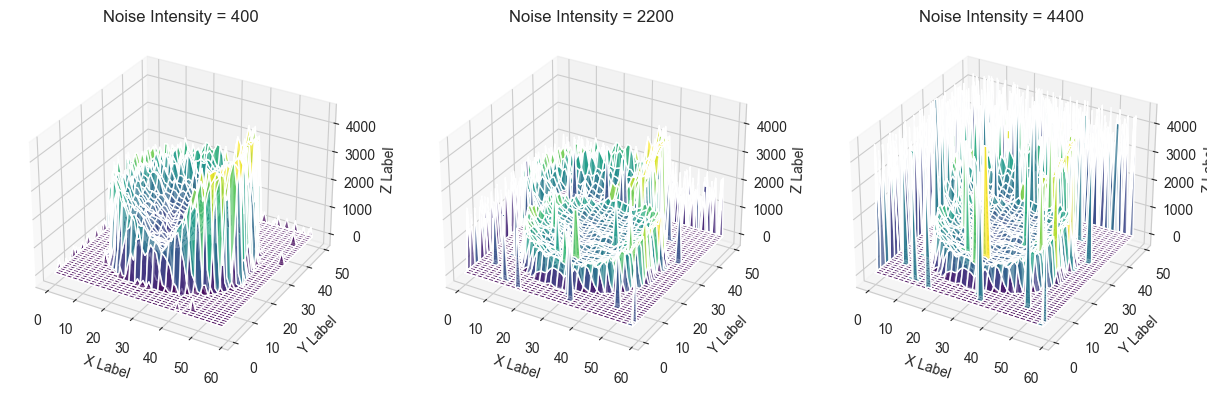

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming "noisy_mats" is a list of noisy matrices with shape (N, M)
# where N is the number of subjects and M is the shape of each matrix
fig = plt.figure(figsize=(15, 5))  # You can adjust the figure size as needed
ax1 = fig.add_subplot(131, projection='3d')  # 1st subplot for noise intensity of 400
ax2 = fig.add_subplot(132, projection='3d')  # 2nd subplot for noise intensity of 2200
ax3 = fig.add_subplot(133, projection='3d')  # 3rd subplot for noise intensity of 4400

for k in range(len(noisy_mats_1)):
    noisy_mat_1 = noisy_mats_1[k]
    noisy_mat_2 = noisy_mats_2[k]
    noisy_mat_3 = noisy_mats_3[k]
    
    N1, M1 = noisy_mat_1.shape
    N2, M2 = noisy_mat_2.shape
    N3, M3 = noisy_mat_3.shape
    
    x1 = range(M1)
    x2 = range(M2)
    x3 = range(M3)
    
    y1 = range(N1)
    y2 = range(N2)
    y3 = range(N3)
    
    X1, Y1 = np.meshgrid(x1, y1)
    X2, Y2 = np.meshgrid(x2, y2)
    X3, Y3 = np.meshgrid(x3, y3)
    
    # Flatten the noisy matrix to use it as the Z coordinate
    Z1 = noisy_mat_1
    Z2 = noisy_mat_2
    Z3 = noisy_mat_3
    
    ax1.plot_surface(X1, Y1, Z1, cmap='viridis', alpha=0.7)
    ax2.plot_surface(X2, Y2, Z2, cmap='viridis', alpha=0.7)
    ax3.plot_surface(X3, Y3, Z3, cmap='viridis', alpha=0.7)

ax1.set_title('Noise Intensity = 400')
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')

ax2.set_title('Noise Intensity = 2200')
ax2.set_xlabel('X Label')
ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z Label')

ax3.set_title('Noise Intensity = 4400')
ax3.set_xlabel('X Label')
ax3.set_ylabel('Y Label')
ax3.set_zlabel('Z Label')

plt.show()

In [32]:
# Compute behavior-spatial covariance matrix
Z = child_adult_final.T
R = np.dot(Z, X.T)                #build cross-correlation matrix R

# Perform Singular Value Decomposition
U, D_2, V = np.linalg.svd(R, full_matrices=False)
D = np.sqrt(D_2)

# Get latent variables 
Ly = np.dot(V, masked_arrays)
Lz = np.dot(U, Z)
print("Latent var y :", Ly.shape, "Latent var z :", Lz.shape)
print('Number of singular values is equal to the number of behavioral measures: ', D.shape[0])

Latent var y : (2, 25) Latent var z : (2, 25)
Number of singular values is equal to the number of behavioral measures:  2


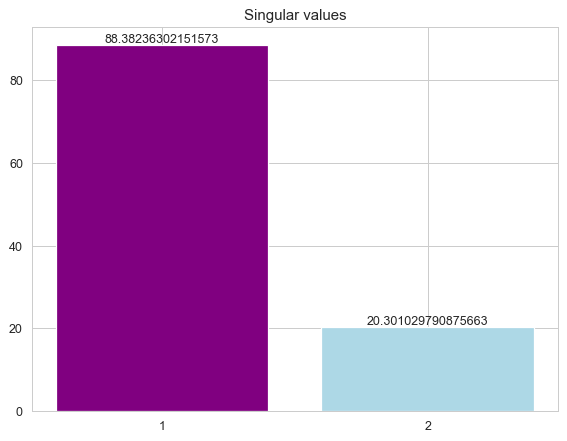

In [33]:
# Visualization
# Plot singular values explaining the covariance between brain contrast maps and behavioral measures
plt.figure(dpi=90)
bar1 = plt.bar(1, D[0] ,color='purple')
bar2 = plt.bar(2, D[1] ,color='lightblue')
for i, rect in enumerate(bar1 + bar2):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{D[i]}', ha='center', va='bottom')
plt.xticks([1,2]) 
plt.tight_layout()
plt.title("Singular values")
plt.show()

Interpretation: 
The purpose of the provided code is to perform Singular Value Decomposition (SVD) to investigate the relationship between brain contrast maps (functional imaging data) and behavioral measures. 

1. **Compute behavior-spatial covariance matrix (R):** The code computes the cross-correlation matrix R between the behavioral measures (child_adult_final) and the masked functional imaging data (masked_arrays). This matrix represents the covariance between the two datasets.

2. **Perform Singular Value Decomposition (SVD):** SVD is applied to the covariance matrix R. It decomposes R into three matrices U, D, and V. D contains the singular values, which represent the importance or strength of the relationships between the behavioral measures and the functional imaging data.

3. **Get latent variables:** The code then calculates the latent variables Ly and Lz by multiplying V with masked_arrays and U with Z, respectively. These latent variables represent the shared information between the two datasets. Ly and Lz provide a representation of the behavioral measures and the functional imaging data in a way that maximizes their covariance.

4. **Interpretation:** The plot showing the singular values (D) serves as a visual representation of the strength of the relationships between the behavioral measures and the functional imaging data. The graph provides insights into how many singular values (components) are significant in explaining the covariance between the two datasets.

- If there are only a few significant singular values (usually indicated by a rapid decrease in magnitude), it suggests that a small number of behavioral measures are strongly related to the functional imaging data. These measures might be key factors in understanding the relationship between brain activity and behavior.
- If there are many significant singular values, it indicates a more complex relationship with multiple behavioral measures contributing to the covariance. In this case, a larger number of measures are important in explaining the relationship.

The height of the bars in the graph represents the magnitude of the singular values (D). If a singular value is large, it implies a strong relationship between the behavioral measures and the functional imaging data. The interpretation of the graph depends on the relative sizes of the singular values and their distribution. 

In summary, this analysis helps identify the most relevant behavioral measures and their impact on brain activity. It can provide insights into which aspects of behavior are strongly associated with the observed brain patterns, potentially leading to a better understanding of the neural basis of certain behaviors or conditions.


--> In our case, having a first singular value significantly larger than the second one indicates that there is a strong and dominant relationship or pattern between the data represented by the first singular vector (U) and the data represented by the second singular vector. 
That the first singular value is approx 1189 and the second 183. For behavioral measures (Child and Adult), it implies that there is a dominant pattern that significantly explains the variance in the data. This could indicate that one of the behavioral categories (either "Child" or "Adult") strongly influences the observed patterns in the brain contrast maps.

In [35]:
print(U.shape)

(2, 2)


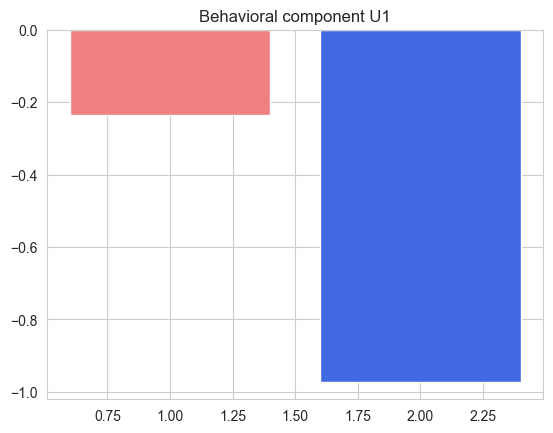

In [36]:
# Plot the behavioral components (matrix U)
# Plot Behavioral Component U1
plt.bar([1,2], U[0,:], color=['lightcoral','royalblue'])
plt.title("Behavioral component U1")
plt.show()

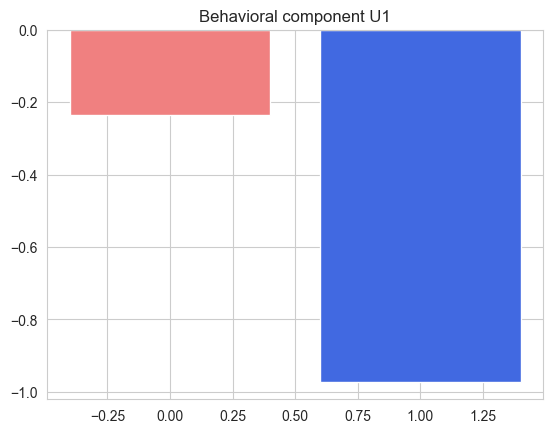

In [37]:
plt.bar(range(len(U[0, :])), U[0, :], color=['lightcoral', 'royalblue'])
plt.title("Behavioral component U1")
plt.show()


Interpretation: The code is plotting the first behavioral component, denoted as `U1`. The `U1` component represents a linear combination of the original behavioral measures. Each element in the `U1` vector corresponds to a weight associated with a specific behavioral measure, with positive and negative values indicating the direction of influence on the component.

In the plot, there are two bars, one in "lightcoral" and the other in "royalblue." The length of the bars indicates the strength of the contribution of each behavioral measure to the `U1` component. 

We can assess which behavioral measures have the most substantial impact on the first behavioral component and whether they positively or negatively influence it.
--> .... further details for our specific case

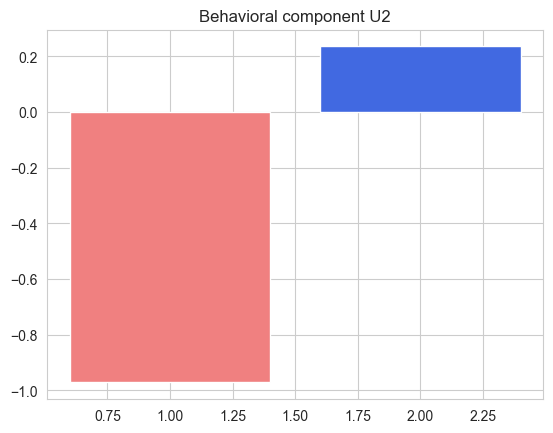

In [38]:
# Plot the behavioral components (matrix U)
# Plot Behavioral Component U2
plt.bar([1,2], U[1,:], color=['lightcoral','royalblue'])
plt.title("Behavioral component U2")
plt.show()

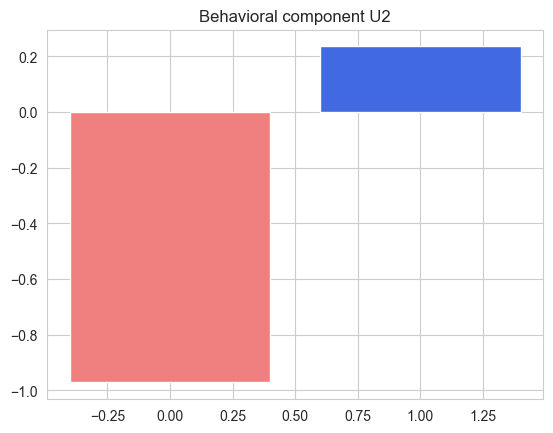

In [39]:
plt.bar(range(len(U[0, :])), U[1, :], color=['lightcoral', 'royalblue'])
plt.title("Behavioral component U2")
plt.show()

### Plot the spatial components (matrix V)

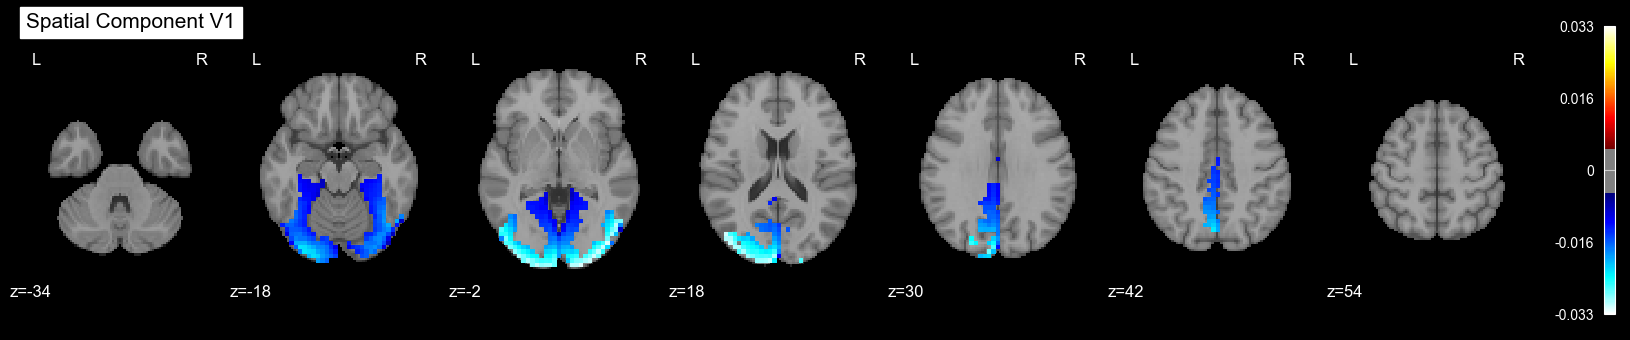

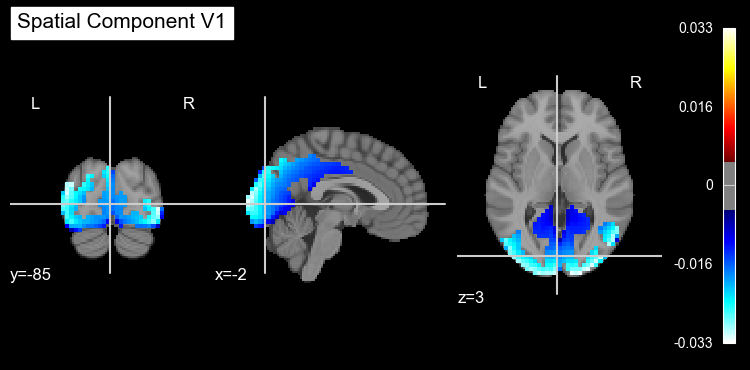

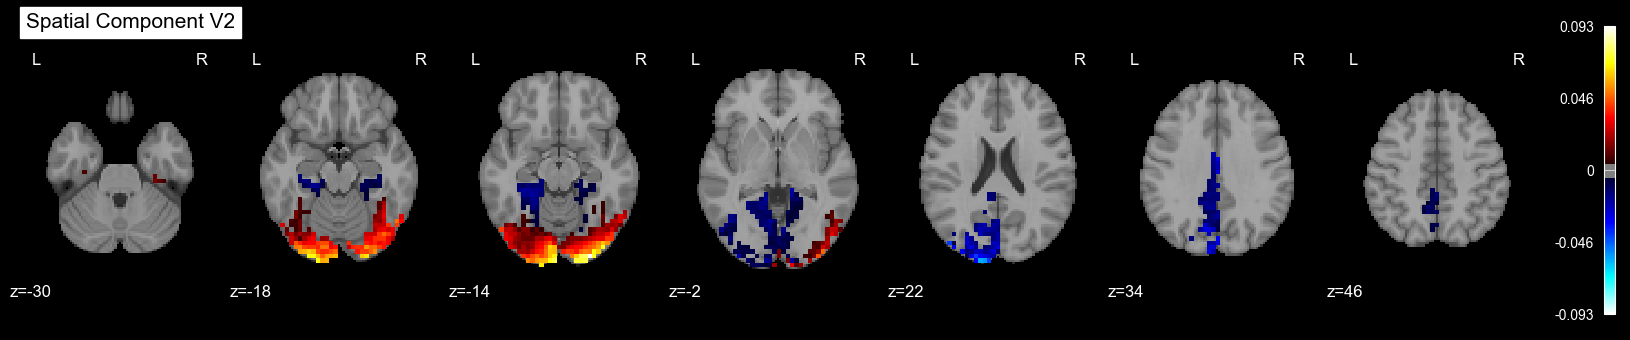

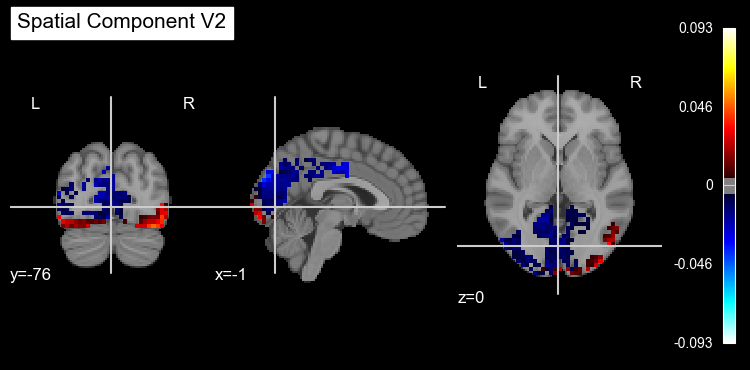

In [44]:
#* Information needed for plotting
#* Read T1-weighted template
T1w_img = nib.load('data/mask/T1w_restore_brain.nii')

# Get affine transform
affine = nib.load(data.func[0].format(1)).affine


#affine = np.array([
#    [-X_DIM, 0, 0, 0],
#    [0, -Y_DIM, 0, 0],
#   [0, 0, N_SLICES, 0],
#    [0, 0, 0, 1]
#]

#Extract the first two spatial components, denoted as V1 and V2, from the matrix V
#Component V1
V1_img = nib.Nifti1Image(np.reshape(V[0,:],(X_DIM, Y_DIM, N_SLICES)), affine)

# Plot different views of the spatial components
desired_views = ['z', 'ortho']
for view_ in desired_views:
    plotting.plot_stat_map(V1_img, display_mode=view_, title='Spatial Component V1',
                    colorbar=True, black_bg=True,  threshold=2*np.std(V[0,:]),)
                    #output_file=save_results + "pls_spatial_V1_{}.png".format(view_)) # uncomment to save plot

#Component V2
V2_img = nib.Nifti1Image(np.reshape(V[1,:],(X_DIM, Y_DIM, N_SLICES)), affine)

# Plot 
desired_views = ['z', 'ortho']
for view_ in desired_views:
    plotting.plot_stat_map(V2_img, display_mode=view_, title='Spatial Component V2',
                    colorbar=True, black_bg=True,  threshold=2*np.std(V[1,:]),)
                    #output_file=save_results + "pls_spatial_V1_{}.png".format(view_)) # uncomment to save plot
#only values above this threshold will be displayed in the plot. This can help highlight regions where the spatial component has a strong influence.

## INTER NOS COMMENT: I'm not sure this is how it's supposed to be done, my questions (will ask them on thursday) are:

*1. Is it correct taking S = sqrt(S2) since SVD performed on cov mat? [SEE SLIDES PART 2-4 PAGE 14]
-> yes*
    
*2. Should we remove (in SVD part) mean over time before svd or maybe mean over something else since time is not a variable we're taking into account?[SEE SLIDES PART 2-4 PAGE 11]
-> yes*


*3. Is z-scoring necessary?* nella prima parte del miniproject con la SVD noi sottriaiamo la media perchè non vogliamo che la PCA ci spieghi anche le differenze tra baselines, cioè standardizziamo 
nella seconda parte lo z score lo facciamo perchè vogliamo standardizzare, ma non ai fini della PCA ma solamente per confrontare

*4. Which T1-weighted template should we use? -> MNI standard* 

*5. TR in the middle or in the first 10 resting-state seconds? It's the same bc we're doing denoising who care* 

*6. Which white noise? -> show different ones*

## We should put a slide for the link between PCA and SVD